In [1]:
"""Lean Project Valuation Model - a three-stage cashflow model.

This simulates a cashflow process that follows geometric brownian motion and
a constant cost rate

Typical usage example:

  foo = ClassFoo()
  bar = foo.FunctionBar()
"""

import numpy as np
from numpy.random import RandomState
from numpy.polynomial import Polynomial
from matplotlib import pyplot as plt
from ipywidgets import interact, IntSlider
from scipy.stats.distributions import lognorm, rv_frozen
from pathlib import Path

In [2]:
# Simulation Parameters
N = 25
T = 3
STEP = 20
TIME_ARRAY = np.linspace(0, T, STEP*T+1)

DRIFT = 0.02
VOL = 1.0
START = 3.0


In [3]:
class CashflowProcess:
    """Cashflow Process - Geometric Brownian Motion.(with optional drift).
    """

    def __init__(self, mu: float = 0.0, sigma: float = 1.0, y0: float = 3.0,):
        """Initializes the instance based on spam preference.
        """
        self.mu = mu
        self.sigma = sigma
        self.y0 = y0

    def _market_sentiment(self, t: np.array, n: int, step: int, rnd: np.random.RandomState) -> np.ndarray:
        """Generates a cumulative product array with uniform distribution draws
        at each interval period
        """
        # create an array of zeros
        time_len = t.size
        arr = np.ones((time_len, n))

        # replace every interval entry with a uniform distribution sample
        i = step
        while i < time_len:
            arr[i] = rnd.uniform(0, 2, size=(1, n))
            i += step
        
        # mask out the shocks
        time_mask = np.tile(np.reshape(t, (-1, 1)), (1, n))
        mask = np.mod(time_mask, 1) == 0
        shocks = np.ma.masked_where(~mask, arr)

        # take the cumulative product to identify the market sentiment effect
        return np.cumprod(arr, axis=0), shocks[~shocks.mask.any(axis=1)]

    def simulate(self, t: np.array, n: int, step: int, rnd: np.random.RandomState) -> np.ndarray:
        """Simulates cashflow process"""
        # verify input
        assert t.ndim == 1, "One dimensional time vector required"
        assert t.size > 0, "At least one time point is required"
        dt = np.concatenate((t[0:1], np.diff(t)))
        assert (dt >= 0).all(), "Increasing time vector required"
        
        dW = (rnd.normal(size=(t.size, n)).T * np.sqrt(dt)).T
        W = np.cumsum(dW, axis=0)

        # market sentiment array
        mkt_sent, shocks = self._market_sentiment(t, n, step, rnd)

        # run simulation
        sim = (self.y0-1) + np.exp(self.sigma * W.T + (self.mu - self.sigma**2 / 2) * t).T
        return sim * mkt_sent, shocks

    def distribution(self, t: float) -> rv_frozen:
        """Return the distribution of the process"""
        mu_t = (self.mu - self.sigma**2 / 2) * t
        sigma_t = self.sigma * np.sqrt(t)
        return lognorm(scale=np.exp(mu_t), s=sigma_t)


In [4]:
# cost process
@np.vectorize
def cost(k):
    return 1.0

# cashflow process
cf = CashflowProcess(mu=DRIFT, sigma=VOL)

# simulation
rnd = RandomState(seed=1234)
cashflow, mkt_shocks = cf.simulate(TIME_ARRAY, N, STEP, rnd)


In [5]:
# # mask integer values so that the plot line breaks
# time_mask = np.tile(np.reshape(TIME_ARRAY, (-1, 1)), (1, N))
# mask = np.mod(time_mask, 1) == 0  # Mask where x is an integer
# cf_masked = np.ma.masked_where(mask, cashflow)
# cf = cashflow

# sort based on final value
sorted_indices = np.argsort(cashflow[-1])
cf_sorted = cashflow[:, sorted_indices]

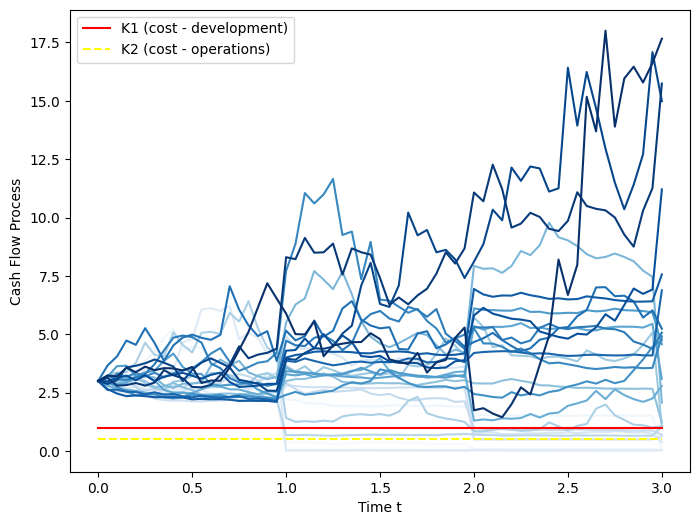


Trials: 25, Drift: 0.02, Vol: 1.0 



In [6]:
# plot cashflow and cost processes
figsize = (8, 6)
plt.figure(figsize=figsize)

plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.Blues(np.linspace(0, 1, N))))
plt.plot(TIME_ARRAY, cf_sorted)

plt.plot(TIME_ARRAY, cost(TIME_ARRAY), color='red', label='K1 (cost - development)')
plt.plot(TIME_ARRAY, cost(TIME_ARRAY)/2, color='yellow', linestyle='dashed', label='K2 (cost - operations)')

plt.xlabel("Time t")
plt.ylabel("Cash Flow Process")
plt.legend(loc='upper left')
plt.show()

txt = f"""
Trials: {N}, Drift: {DRIFT}, Vol: {VOL} 
"""
print(txt)


In [7]:
def comparison_fn(cf_arr, c0):
    """Comparison Function
    Generate a comparison array against which we will compare cashflows
    at each interval
    """
    # we'll just compare against C_0 for now
    c = np.ones(cf_arr.shape) * c0
    return c


def decision_fn(cf_arr, comp_arr):
    """ Decision Function
    returns a decision array given an array of cashflows and a
    comparison array
    """
    d = np.zeros(cf_arr.shape)
    i = 0
    while i < cf_sorted.shape[0]:
        d[i] = np.sign(cf_arr[i] - comp_arr[i])
        i += STEP
    return d


# create comparisons and use that to generate decisions
comparisons = comparison_fn(cf_sorted, START)
decisions = decision_fn(cf_sorted, comparisons)

# history array - we need memory of the past
cumulatives = np.cumsum(decisions, axis=0)
history = cumulatives  #np.insert(cumulatives, 0, 0, axis=0).shape[0]


In [8]:
# init constants
FIRST_DEC_POINT = 2 * STEP
NOBS = TIME_ARRAY.shape[0]

In [9]:
# given no prior exercise we just receive the cashflow
cashflow = cf_sorted

# populate a results array for exercises and non-exercises
decision_results = []

# Determine completion, abandonment, and continuation series
completion_times = {}
completion_vals = {}
abandon_times = {}
abandon_vals = {}
success_times = {}
success_vals = {}
failure_times = {}
failure_vals = {}
continue_times = {}
continue_vals = {}



# iterate backward over time steps
idx = int(TIME_ARRAY[-1] * STEP)
path_results = {}
while idx > 0:
    if idx < FIRST_DEC_POINT: break

    remaining_paths = cashflow[idx, :]
    dec_arr = decisions[idx]  
    cf_arr = cashflow[idx]
    hist = history[idx]

    # iterate over paths at this time step
    for path_id, d in enumerate(dec_arr):
        # store history, exercise time, and exercise value
        h = hist[path_id]
        ex_time = TIME_ARRAY[idx]
        ex_val = cf_arr[path_id]
        # TODO: refactor into its own process
        real_cf_time = 3*STEP

        if d > 0 and h == 2:
            ex_type = 0  # early completion
            # exercise time and value
            completion_times[path_id] = ex_time
            completion_vals[path_id] = ex_val
            # add exercise type, time, and paths to results
            path = np.concatenate(
                (cashflow[:,path_id][:idx+1],
                np.repeat(ex_val, real_cf_time))
            )
            path_results[path_id] = (ex_type, idx, ex_time, ex_val, path)
            
        elif d < 0 and h == -2:
            ex_type = 1  # early abandonment
            abandon_times[path_id] = ex_time
            abandon_vals[path_id] = ex_val
            path = np.concatenate(
                (cashflow[:,path_id][:idx+1],
                np.repeat(0, real_cf_time))
            )
            path_results[path_id] = (ex_type, idx, ex_time, ex_val, path)
            
        elif d > 0 and h > 0:
            ex_type = 2  # success
            success_times[path_id] = ex_time
            success_vals[path_id] = ex_val
            path = np.concatenate(
                (cashflow[:,path_id][:idx+1],
                np.repeat(ex_val, real_cf_time))
            )
            path_results[path_id] = (ex_type, idx, ex_time, ex_val, path)
            
        elif d < 0 and h < 0:
            ex_type = 3  # failure
            failure_times[path_id] = ex_time
            failure_vals[path_id] = ex_val 
            path = np.concatenate(
                (cashflow[:,path_id][:idx+1],
                np.repeat(0, real_cf_time))
            )
            path_results[path_id] = (ex_type, idx, ex_time, ex_val, path)
        else:  # continuation
            continue_times[path_id] = ex_time
            continue_vals[path_id] = ex_val
    idx -= STEP

In [10]:
# Helper Functions
def d2sl(d):
    """Dict to sorted list"""
    return [v for k, v in sorted(d.items())]


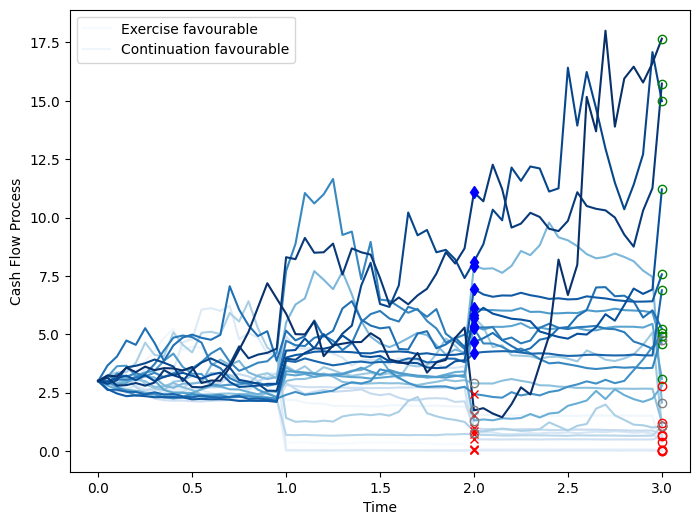

In [11]:
# Plot exercise and continuation
grey, green = "#dddddd", "#afe1af"
figsize = (8, 6)
plt.figure(figsize=figsize)
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.Blues(np.linspace(0, 1, N))))
plt.plot(TIME_ARRAY, cf_sorted)
plt.plot(d2sl(completion_times), d2sl(completion_vals), "bd")
plt.plot(d2sl(abandon_times), d2sl(abandon_vals), "rx")
plt.plot(d2sl(success_times), d2sl(success_vals), "go", markerfacecolor='none')
plt.plot(d2sl(failure_times), d2sl(failure_vals), "ro", markerfacecolor='none')
plt.plot(d2sl(continue_times), d2sl(continue_vals), "o", color="grey", markerfacecolor='none')
plt.legend(["Exercise favourable", "Continuation favourable"])
plt.xlabel("Time")
plt.ylabel("Cash Flow Process")
plt.show()


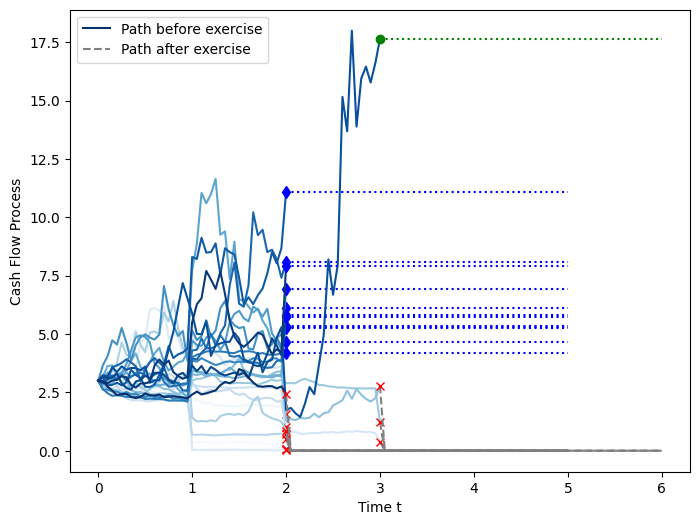

In [12]:
# Formatting for decision types
FORMATS = {
    0: ("--", "grey", "d", "blue", ":", "blue"),  # completion
    1: ("--", "grey", "x", "red", "--", "grey"),    # abandon
    2: ("--", "grey", "o", "green", ":", "green"), # success
    3: ("--", "grey", "x", "red", "--", "grey"),    # failure
}

# Plot exercise and continuation
grey = "#dddddd"
figsize = (8, 6)
plt.figure(figsize=figsize)
plt.gca().set_prop_cycle(
    plt.cycler('color', plt.cm.Blues(np.linspace(0, 1, N)))
)

# given ex_id, cf, ex_line, ex_color, pre_ex_line, pre_ex_color, post_ex_line, post_ex_color, 
n_timesteps, n_paths = cashflow.shape
for ex_type, ex_idx, ex_time, ex_val, path in path_results.values():
    # create a new time array depending on the length of the path
    nobs = path.shape[0]-1
    TIME_ARRAY = np.linspace(0, nobs/STEP, nobs+1)

    # active paths
    (handle_path,) = plt.plot(
        TIME_ARRAY[0 : ex_idx+1],
        path[0 : ex_idx+1],
    )
    # stopped paths
    (handle_stopped_path,) = plt.plot(
        TIME_ARRAY[ex_idx :],
        path[ex_idx :],
        FORMATS[ex_type][4],
        color=FORMATS[ex_type][5] 
    )
    # exercise point
    (handle_first_ex,) = plt.plot(
        ex_time, ex_val,
        FORMATS[ex_type][2],
        color=FORMATS[ex_type][3]
    )

plt.legend(
    [handle_path, handle_stopped_path],
    ["Path before exercise", "Path after exercise"],
)
plt.xlabel("Time t")
plt.ylabel("Cash Flow Process")
plt.show()